# Comparison of Neural Models on pretrained Word2Vec embeddings

## Feedforward Neural Network

Following an experiment to compare neural models, we discovered odd results showing that bag of words could outperform embeddings. This experiment attempts to tweak the embeddings to show the expected results under the assumption that the problem is not the amount of data. If the problem is the amount of data we will investigate this in another experiment.

Again, we will show Bag of Words results:

In [6]:
from scripts import training_helpers
from scripts.cross_validate import run_cross_validate
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Embedding, MaxPooling2D, LSTM
from tensorflow.keras.regularizers import l2
from pandas import DataFrame
from seaborn import boxplot
import matplotlib.pyplot as plt
import json

import gensim
import numpy as np

read_existing_embeddings = False

In [2]:
data_frame = training_helpers.get_data_frame()
raw_features = data_frame['review']
labels = [x for x in data_frame['deceptive']]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(raw_features)
bow_features = tokenizer.texts_to_matrix(raw_features, mode='tfidf')

In [3]:
corpus_words = tokenizer.word_index
corpus_vocab_size = len(corpus_words)+1

In [4]:
def get_ff_bow_model():
  model = Sequential([
      Dense(16, activation=relu, input_shape=(corpus_vocab_size,), kernel_regularizer=l2(0.01)),
      Dropout(0.25),
      Dense(8, activation=relu, kernel_regularizer=l2(0.01)),
      Dense(1, activation=sigmoid)
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

ff_bow_scores = run_cross_validate(get_ff_bow_model, bow_features, labels, cv=10, verbose=0)

Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 129us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 115us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 130us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 204us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 121us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 108us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 130us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 108us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 139us/step
Fitting with:  (1440, 9839) labels (1440,)
160/160 [==============================] - 0s 115us/step


And now we will get results for embeddings. This time I will use pretrained Word2Vec. Although this was not trained directly on words from our dataset, the Word2Vec has a higher dimensionality (making it harder to run on our machines) and so may show better results.

In [7]:
embedding_matrix = None
embedding_length = 0
if read_existing_embeddings:
  embedding_length=300
  embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
  with open('data.json', 'r') as infile:
      data = json.load(infile)
      for i in range(len(data)):
          embedding_matrix[i] = np.array(data[i], dtype=np.float32)
else:
  word_vectors = gensim.models.KeyedVectors.load_word2vec_format("../data/embeddings/GoogleNews-vectors-negative300.bin",
                                                                 binary=True)
  embedding_length = word_vectors.vector_size
    
  embedding_matrix = np.zeros((corpus_vocab_size, embedding_length))
  for word, index in corpus_words.items():
    if word in word_vectors.vocab:
      embedding_matrix[index] = np.array(word_vectors[word], dtype=np.float32)

  with open('data.json', 'w') as outfile:
      json.dump(embedding_matrix.tolist(), outfile)

In [8]:
def get_ff_wv_model():
  model_ff_wv = Sequential([
      Embedding(corpus_vocab_size, embedding_length, weights=[embedding_matrix], trainable=False,
                input_length=corpus_vocab_size),
      Flatten(),
      Dense(16, activation=relu, kernel_regularizer=l2(0.01)),
      Dropout(0.25),
      Dense(8, activation=relu, kernel_regularizer=l2(0.01)),
      Dense(1, activation=sigmoid)
  ])
  model_ff_wv.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model_ff_wv

In [ ]:
ff_wv_scores = run_cross_validate(get_ff_wv_model, bow_features, labels, cv=5)

In [ ]:
print ("Bag of words: ", ff_bow_scores['accuracies'])
print ("Word vectors: ", ff_wv_scores['accuracies'])

ff_scores_entries =[('Bag of Words', x) for x in ff_bow_scores['accuracies']] + [('Word Vectors', x) for x in ff_wv_scores['accuracies']]
ff_scores_data_frame = DataFrame(ff_scores_entries, columns=['input type', 'accuracy'])

In [ ]:
boxplot(x='input type', y='accuracy', data=ff_scores_data_frame)
plt.show()

![](https://i.imgur.com/aiWQUvv.png)

It looks like word vectors are doing better now! Although they should be more accurate than Bag of Words, unless this is an exceptional case. The next step here is to investigate how BoW and word vectors perform on more data, since a small amount of data is a case known to cause results like this. It is also very unlikely Bag of Words will perform as well on a large dataset.

## Convolutional Neural Network

Research has shown that word embeddings perform better than Bag of Words (Convolutional Neural Networks for Sentence Classification, Yoon Kim 2014). We will use our convolutional network on pretrained Word2Vec embeddings to see if we obtain an improved accuracy. First we will obtain results for bag of words again:

In [13]:
batches = 1600
convolutional_data = np.array(np.split(np.array([[[y] for y in z] for z in bow_features]), batches))
convolutional_data.shape

(1600, 1, 9839, 1)

In [14]:
def get_conv_bow_model():
  model = Sequential([
      Conv2D(
          filters=50,
          kernel_size=(1, 10),
          data_format="channels_last",
          input_shape=(1, corpus_vocab_size, 1),
          activation=relu),
      MaxPooling2D(pool_size=(1, 10)),
      Dropout(0.2),
      Flatten(),
      Dense(2, activation='softmax')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

conv_bow_scores = run_cross_validate(get_conv_bow_model, convolutional_data, labels, cv=10, categorical=True)

Fitting with:  (1440, 1, 9839, 1) labels (1440, 2)
Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [==============================] - 18s 18ms/step - loss: 0.4673 - acc: 0.7736 - val_loss: 0.6609 - val_acc: 0.6328
Epoch 2/12
1007/1007 [==============================] - 18s 18ms/step - loss: 0.1416 - acc: 0.9543 - val_loss: 0.7442 - val_acc: 0.6374
Epoch 3/12
1007/1007 [==============================] - 14s 14ms/step - loss: 0.0840 - acc: 0.9682 - val_loss: 0.8427 - val_acc: 0.6212
Epoch 4/12
1007/1007 [==============================] - 19s 19ms/step - loss: 0.0469 - acc: 0.9930 - val_loss: 1.0039 - val_acc: 0.6143
Epoch 5/12
160/160 [==============================] - 1s 6ms/step
Fitting with:  (1440, 1, 9839, 1) labels (1440, 2)
Train on 1007 samples, validate on 433 samples
Epoch 1/12
1007/1007 [==============================] - 16s 16ms/step - loss: 0.4866 - acc: 0.7617 - val_loss: 0.6351 - val_acc: 0.6559
Epoch 2/12
1007/1007 [==============================] - 14

We filter out reviews with more than 300 words because a small number have an exceptionally large number of words and dramatically increase the memory requirements. These reviews are rare and are not expected to provide much value, while also preventing this experiment from being run on a normal machine, so I will filter them out

In [20]:
reviews_words = []
conv_wv_labels = []
for i, raw_feature in enumerate(raw_features):
    word_sequence = text_to_word_sequence(raw_feature)
    if len(word_sequence) > 300:
        continue
    conv_wv_labels.append(labels[i])
    reviews_words.append(word_sequence)
max_review_len = max([len(x) for x in reviews_words])

vectorized_reviews = np.zeros((len(reviews_words), 1, max_review_len, 300))
for i, review in enumerate(reviews_words):
    for j, word in enumerate(review):
        vectorized_reviews[i][0][j] = [x for x in embedding_matrix[corpus_words[word]]]

In [17]:
def get_conv_wv_model():
  model = Sequential([
      Conv2D(
          filters=50,
          kernel_size=(10, 300),
          data_format="channels_first",
          input_shape=(1, 300, 300),
          activation=relu),
      MaxPooling2D(strides=(1, 1), pool_size=(2, 1), data_format="channels_first"),
      Dropout(0.2),
      Flatten(),
      Dense(2, activation='softmax')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

conv_wv_scores = run_cross_validate(get_conv_wv_model, vectorized_reviews, conv_wv_labels, cv=6, categorical=True)

Fitting with:  (1254, 1, 300, 300) labels (1254, 2)
Train on 877 samples, validate on 377 samples
Epoch 1/12
877/877 [==============================] - 17s 20ms/step - loss: 0.6448 - acc: 0.6192 - val_loss: 0.5773 - val_acc: 0.7029
Epoch 2/12
877/877 [==============================] - 13s 15ms/step - loss: 0.4310 - acc: 0.7925 - val_loss: 0.5165 - val_acc: 0.7427
Epoch 3/12
877/877 [==============================] - 13s 15ms/step - loss: 0.2388 - acc: 0.9065 - val_loss: 0.5490 - val_acc: 0.7241
Epoch 4/12
877/877 [==============================] - 13s 15ms/step - loss: 0.1034 - acc: 0.9795 - val_loss: 0.5430 - val_acc: 0.7533
Epoch 5/12
877/877 [==============================] - 13s 15ms/step - loss: 0.0381 - acc: 0.9966 - val_loss: 0.5544 - val_acc: 0.7507
Epoch 6/12
252/252 [==============================] - 2s 7ms/step
Fitting with:  (1254, 1, 300, 300) labels (1254, 2)
Train on 877 samples, validate on 377 samples
Epoch 1/12
877/877 [==============================] - 17s 19ms/step 

In [18]:
print ("Bag of words: ", conv_bow_scores['accuracies'])
print ("Word vectors: ", conv_wv_scores['accuracies'])

conv_scores_entries =[('Bag of Words', x) for x in conv_bow_scores['accuracies']] + [('Word Vectors', x) for x in conv_wv_scores['accuracies']]
conv_scores_data_frame = DataFrame(conv_scores_entries, columns=['input type', 'accuracy'])

Bag of words:  [0.825, 0.80625, 0.8, 0.8625, 0.81875, 0.75625, 0.8625, 0.7625, 0.79375, 0.8375]
Word vectors:  [0.7658730168191213, 0.8055555527172391, 0.7888446222263503, 0.7729083672462707, 0.7839999980926514, 0.7400000014305115]


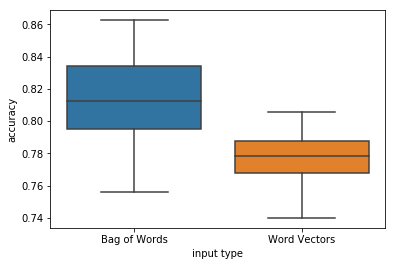

In [19]:
boxplot(x='input type', y='accuracy', data=conv_scores_data_frame)
plt.show()

Again our results look better. If this continues to be consistent we know that Word2Vec has some property that is beneficial, which may be training on more data, or it may be the higher vector dimensionality.

## Recurrent Neural Network (LSTM)

The final experiment we will run to test the results of using pretrained Word2Vec embeddings will be our LSTM network. 
In the previous test we did with word embeddings, our accuracy was 50%, so simply a random guess. Following the trend above of pretrained embeddings giving us better accuracies, we will run a test and see if this can give any improvements for the LSTM network.

First, let's get our BOW accuracies.

In [48]:
batches = 1600
padded = pad_sequences(bow_features)
rnn_bow = np.array(np.split(padded, batches))
max_len_bow = max([len(x) for x in padded])
rnn_bow_targets = np.array([[x] for x in labels])

def get_rnn_bow_model():
  model = Sequential([
      LSTM(20, input_shape=(1, max_len_bow)),
      Dense(1, activation='sigmoid')
  ])
  model.compile(
      loss='binary_crossentropy',
      optimizer='adam',
      metrics=['accuracy'])
  return model

rnn_bow_scores = run_cross_validate(get_rnn_bow_model, rnn_bow, rnn_bow_targets, cv=5)

Fitting with:  (1280, 1, 9839) labels (1280, 1)
Train on 896 samples, validate on 384 samples
Epoch 1/12
896/896 [==============================] - 13s 15ms/step - loss: 0.5607 - acc: 0.7277 - val_loss: 0.3866 - val_acc: 0.8646
Epoch 2/12
896/896 [==============================] - 3s 4ms/step - loss: 0.1078 - acc: 0.9810 - val_loss: 0.3294 - val_acc: 0.8750
Epoch 3/12
896/896 [==============================] - 3s 4ms/step - loss: 0.0323 - acc: 0.9967 - val_loss: 0.3371 - val_acc: 0.8776
Epoch 4/12
896/896 [==============================] - 3s 4ms/step - loss: 0.0162 - acc: 1.0000 - val_loss: 0.3449 - val_acc: 0.8828
Epoch 5/12
896/896 [==============================] - 4s 4ms/step - loss: 0.0099 - acc: 1.0000 - val_loss: 0.3536 - val_acc: 0.8776
Epoch 6/12
320/320 [==============================] - 0s 354us/step
Fitting with:  (1280, 1, 9839) labels (1280, 1)
Train on 896 samples, validate on 384 samples
Epoch 1/12
896/896 [==============================] - 15s 16ms/step - loss: 0.5472

BOW again gives us astoundingly good accuracies, but of course, because it's over a tiny amount of data.

Now let's try our pretrained Word2Vec embeddings, and compare it to our previous OpSpam embeddings.

In [54]:
predictors_sequences = pad_sequences(tokenizer.texts_to_sequences(raw_features))
max_len = max([len(x) for x in predictors_sequences])

def get_lstm_wv_model():
  model = Sequential([
        Embedding(corpus_vocab_size, embedding_length, weights=[embedding_matrix], input_length=max_len, trainable=False),
        LSTM(10),
        Dense(1, activation=sigmoid)
  ])
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

rnn_wv_scores = run_cross_validate(get_lstm_wv_model, predictors_sequences, labels, cv=5, verbose=1, epochs=12, batch_size=64, shuffle=True)


Fitting with:  (1280, 784) labels (1280,)
Train on 896 samples, validate on 384 samples
Epoch 1/12
896/896 [==============================] - 45s 50ms/step - loss: 0.6931 - acc: 0.5078 - val_loss: 0.6876 - val_acc: 0.5599
Epoch 2/12
896/896 [==============================] - 31s 34ms/step - loss: 0.6858 - acc: 0.5647 - val_loss: 0.6814 - val_acc: 0.5703
Epoch 3/12
896/896 [==============================] - 32s 36ms/step - loss: 0.6773 - acc: 0.6027 - val_loss: 0.6700 - val_acc: 0.6068
Epoch 4/12
896/896 [==============================] - 36s 40ms/step - loss: 0.6606 - acc: 0.6373 - val_loss: 0.6542 - val_acc: 0.6250
Epoch 5/12
896/896 [==============================] - 33s 37ms/step - loss: 0.6486 - acc: 0.6161 - val_loss: 0.6439 - val_acc: 0.6250
Epoch 6/12
896/896 [==============================] - 34s 38ms/step - loss: 0.6370 - acc: 0.6306 - val_loss: 0.6120 - val_acc: 0.7031
Epoch 7/12
896/896 [==============================] - 34s 38ms/step - loss: 0.5851 - acc: 0.7109 - val_loss:

320/320 [==============================] - 3s 9ms/step


In [55]:
print ("Bag of words: ", rnn_bow_scores['accuracies'])
print ("Word vectors: ", rnn_wv_scores['accuracies'])

rnn_scores_entries =[('Bag of Words', x) for x in rnn_bow_scores['accuracies']] + [('Word Vectors', x) for x in rnn_wv_scores['accuracies']]
rnn_scores_data_frame = DataFrame(rnn_scores_entries, columns=['input type', 'accuracy'])

Bag of words:  [0.88125, 0.8375, 0.8625, 0.915625, 0.846875]
Word vectors:  [0.721875, 0.64375, 0.696875, 0.621875, 0.509375]


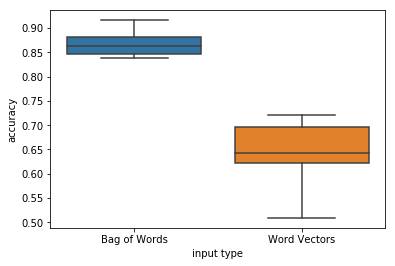

In [56]:
boxplot(x='input type', y='accuracy', data=rnn_scores_data_frame)
plt.show()

We are still seeing much higher results for BOW, however our pretrained vectors are doing better than the custom ones trained on the OpSpam dataset. This shows us conclusively that word embeddings do have some value, though perhaps not on a dataset as small as this. When we test over our full